In [1]:
### Important links: 
## https://nicharuc.github.io/topic_modeling/#topic=0&lambda=1&term=
## https://realpython.com/pandas-python-explore-dataset/

In [2]:
# Settings for quick access
# 2022_03_23 NEXT BELOW == 10; 20
k_one = 0
k_two = 0
no_below_input = 20
no_above_input = 0.6
passes_amount = 40
iterations_amount = 500

In [3]:
# Ignore warnings that refer to upcoming changes in programs
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
# UTILITY CODE:

# This section is important to be able to open large dataframes, redefining the memory limit.
# Be careful not to mess with this as this can drastically affect memory:

# Data matrix and data frame are huge files, these lines are required to open them:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
        
# https://stackoverflow.com/questions/15063936/csv-error-field-larger-than-field-limit-131072

In [5]:
## Import libraries
import spacy
import nltk

# nltk.download('averaged_perceptron_tagger')
import re
import string
import pandas as pd
pd.set_option("display.max.columns", None)
import numpy as np

import gensim
from gensim import corpora
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [6]:
## Paths
path = './spreadsheets/'
df_nnovels_corpus = 'df_nnovels_full.csv'
df_txtlab_corpus = 'df_txtlab_full.csv'
path_to_assets = './assets/'
stop_all = path_to_assets + 'stopall.txt'
stop_names = path_to_assets + 'stopnames.txt'

with open(stop_all, 'r') as stop_all_o:
    stop_word_list = stop_all_o.read().split()

In [7]:
# FUNCTIONS 1:
# Progress bar to follow up on what's happing while running code:
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    
    #old: percents = round(100.0 * count / float(total), 1)
    percents = round(100.1 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()  # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#novel_text50529068_27871113)

# for metadata output:
def output_metadata(df, spreadsheet_name = 'BLA', path_output = './spreadsheets/'):
    list_of_columns_not_to_include = ['words_standardized_stopped', 'sentences_standardized_stopless','words_as_string_for_vectorizor', 'dirty_text']
    columns_to_include = [column_name for column_name in df.columns.values.tolist() if column_name.lower() not in list_of_columns_not_to_include]
    df_meta = df[columns_to_include]
    df_meta.to_csv(path_output + spreadsheet_name + '.csv')
    print(spreadsheet_name + ' was saved in '+str(path_output))
    
# for full output:
def output_full(df, spreadsheet_name = 'BLA', path_output = './spreadsheets/'):
    df.to_csv(path_output + spreadsheet_name + '.csv')
    print(spreadsheet_name + ' was saved in '+str(path_output))

# for inporting df to pandas
def open_df_and_print(file_name = 'df_full.csv', path_output = './spreadsheets/', drop_first_column=False):
    df = pd.read_csv(path_output + file_name, engine='python')
    if drop_first_column == True:
        df.drop(df.columns[0], axis=1, inplace=True)
    return df

In [8]:
### Cleaning

nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2069077
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}


def clean_all(df, col_name):
    """
    Combines all functions used to clean and lemmatize the comments.
    :param df: data frame with comments
    :param col_name: column name in data frame containing comments
    :return: data frame with comments column lemmatized
    """

    # encode for only ascii characters
    df[col_name] = df[col_name].map(ascii_rm)
    print("finished getting ascii only chars")
    # lowercase texts
    df[col_name] = df[col_name].map(lambda x: x.lower())
    print("finished lowercasing")

    # lemmatize words
    df[col_name] = df[col_name].astype(str).map(lemma)
    print("finished lemmatizing")
    # remove punctuation
    df[col_name] = df[col_name].map(punc_n)
    print("finished removing punctuation")

    # filter only english comments/non blank comments
    # df['language'] = df[col_name].map(get_language)
    # df = df.loc[df['language'] == 'english']
    # df = df.drop('language', axis=1)
    # df = df[df[col_name] != ""]
    
    return df


def ascii_rm(comment):
    """
    Parses comments and keep only ascii characters
    :param comment: a comment
    :return: comment with only ascii characters
    """
    comment = comment.encode('ascii', errors = 'ignore')
    return comment

def get_language(text):
    """
    Determines what language the comment is written in and filters only English comments.
    :param text: comment
    :return: language of comment
    """
    words = set(nltk.wordpunct_tokenize(text.lower()))
    return max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]


def punc_n(comment):
    """
    Removes punctuations from comments.
    :param comment: a comment
    :return: comment without punctuations
    """
    regex = re.compile('[' + re.escape('!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~')+'0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", comment)
    nopunct_words = nopunct.split(' ')
    filter_words = [word.strip() for word in nopunct_words if word != '']
    words = ' '.join(filter_words)
    return words



def lemma(comment):
    """
    Lemmatize comments using spacy lemmatizer.
    :param comment: a comment
    :return: lemmatized comment
    """
    lemmatized = nlp(comment)
    lemmatized_final = ' '.join([word.lemma_ for word in lemmatized if word.lemma_ != '\'s'])
    return lemmatized_final

In [9]:
# ### Load the data
# df_nnovels_full = open_df_and_print(file_name = df_nnovels_corpus, path_output = path, drop_first_column=True)
# df_nnovels_full.head()

In [10]:
# ### Extract only cleaned text
# clean_text = pd.DataFrame(df_nnovels_full.words_as_string_for_vectorizor)
# clean_text = clean_all(clean_text, 'words_as_string_for_vectorizor')

In [11]:
clean_text_nnovels_for_tm_filtered = open_df_and_print(file_name = 'clean_text_nnovels_for_tm_filtered.csv', path_output = './spreadsheets/', drop_first_column=True)

In [12]:
# clean_text_nnovels_for_tm_filtered.head()

In [13]:
# output_full(clean_text_nnovels_for_tm_filtered, spreadsheet_name = 'clean_text_nnovels_for_tm_filtered', path_output = './spreadsheets/')

In [14]:
## Form Bigrams and Trigrams for better topics


bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([novel_text.split() for novel_text in clean_text_nnovels_for_tm_filtered.words_as_string_for_vectorizor])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)



In [15]:


trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([novel_text.split() for novel_text in clean_text_nnovels_for_tm_filtered.words_as_string_for_vectorizor])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)



In [16]:


bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)



In [17]:


trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)



In [18]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [19]:


# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 



In [20]:


# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]



In [21]:


# examples of bigrams
bigrams[:10]



['kirylo sidorovitch',
 'councillor mikulin',
 'san francisco',
 'otway bethel',
 'reb shemuel',
 'lu cretia',
 'granville varney',
 'gilbert arnold',
 'rosanna spearman',
 'thorpe ambrose']

In [22]:
# examples of trigrams
trigrams[:10]

['mme de brecourt',
 'madame max goesler',
 'leicester dedlock baronet',
 'lord mount severn',
 'madame de castella',
 'sir rupert lisle',
 'sir leicester dedlock',
 'mr godfrey ablewhite',
 'mr ben allen',
 'carleton st john']

In [23]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [24]:
novels_w_ngrams = clean_text_nnovels_for_tm_filtered.copy()

In [25]:
# merging ngrams with    "_"
novels_w_ngrams.words_as_string_for_vectorizor = novels_w_ngrams.words_as_string_for_vectorizor.map(lambda x: replace_ngram(x))

In [26]:


# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
novels_w_ngrams = novels_w_ngrams.words_as_string_for_vectorizor.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and len(word) > 2])



In [27]:
novels_w_ngrams.head()

0    [parsonage, true, history, instruction, treasu...
1    [traveler, opening, season, eighteen_hundred, ...
2    [rich, banker, marry, actress, faint, streak, ...
3    [crisped, shade, bower, revel, spruce, jocund,...
4    [house, bloomsbury, house, whereof, outward, a...
Name: words_as_string_for_vectorizor, dtype: object

In [28]:


# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered



In [29]:
final_texts = novels_w_ngrams.map(noun_only)

In [30]:
# output_full(final_texts, spreadsheet_name = 'final_texts_for_TM', path_output = './spreadsheets/')

In [31]:
# final_texts = open_df_and_print(file_name = 'final_texts_for_TM.csv', path_output = './spreadsheets/', drop_first_column=True)

In [32]:
## RUN FROM HERE
# final_texts = open_df_and_print(file_name = 'final_texts_for_TM.csv', path_output = './spreadsheets/', drop_first_column=True)

In [33]:
### LDA Model Begins

In [34]:
dictionary = corpora.Dictionary(final_texts)
dictionary.filter_extremes(no_below=no_below_input, no_above=no_above_input, keep_n=100000)

In [35]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_texts]

In [36]:


coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=passes_amount,\
                   iterations=iterations_amount, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_texts,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))




Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


In [37]:


x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]



In [38]:
# grabbing k with highest and second highest coherence
highest_coherence = 0
second_highest_coherence = 0
for i in range(len(y_val)):
    if y_val[i] > highest_coherence:
        highest_coherence = y_val[i]
        k_one = x_val[i]
    if y_val[i] < highest_coherence:
        if y_val[i] > second_highest_coherence:
            second_highest_coherence = y_val[i]
            k_two = x_val[i]

In [39]:
print(x[1] for x in coherence)

<generator object <genexpr> at 0x000001DCFBB31CC8>


In [40]:
print(k_one)
print(highest_coherence)
print(k_two)
print(second_highest_coherence)

22
0.308210560127349
23
0.30139535178896754


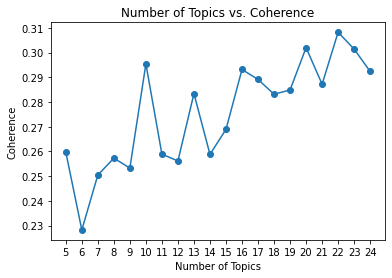

In [41]:


plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()



In [42]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=k_one, id2word = dictionary, passes=passes_amount,\
               iterations=iterations_amount,  chunksize = 10000, eval_every = None, random_state=0)

In [43]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=k_two, id2word = dictionary, passes=passes_amount,\
               iterations=iterations_amount,  chunksize = 10000, eval_every = None, random_state=0)

In [44]:
# To show initial topics from model 1
ldamodel.show_topics(k_one, num_words=15, formatted=False)

[(0,
  [('honor', 0.023164134),
   ('color', 0.014334909),
   ('camp', 0.012832361),
   ('comrade', 0.007932314),
   ('madame', 0.007798824),
   ('regiment', 0.0077337986),
   ('rake', 0.0072077895),
   ('tent', 0.006744198),
   ('monsieur', 0.0058405),
   ('ivory', 0.005581982),
   ('haughty', 0.005198289),
   ('rider', 0.0050165034),
   ('troop', 0.0049735326),
   ('favor', 0.004850257),
   ('hound', 0.0046872804)]),
 (1,
  [('baronet', 0.05030698),
   ('rector', 0.023754904),
   ('steward', 0.018269567),
   ('curate', 0.012530372),
   ('gipsy', 0.012494297),
   ('pony', 0.011792559),
   ('colonel', 0.010540344),
   ('brighton', 0.007228169),
   ('postman', 0.0071583637),
   ('lass', 0.006959886),
   ('moustache', 0.006912256),
   ('tramp', 0.0069103655),
   ('con', 0.0065835076),
   ('valet', 0.0062692324),
   ('mare', 0.004909538)]),
 (2,
  [('editor', 0.0072214645),
   ('dragon', 0.006605152),
   ('colonel', 0.0058289478),
   ('dock', 0.0045550233),
   ('illustration', 0.004549133

In [45]:
# To show initial topics from model 2
ldamodel2.show_topics(k_two, num_words=15, formatted=False)

[(0,
  [('honor', 0.017665913),
   ('camp', 0.014682981),
   ('color', 0.013364142),
   ('madame', 0.012577185),
   ('comrade', 0.010358614),
   ('regiment', 0.009036966),
   ('monsieur', 0.008993142),
   ('tent', 0.00784528),
   ('rake', 0.0077470597),
   ('ivory', 0.0067026005),
   ('troop', 0.0059424825),
   ('haughty', 0.0056064893),
   ('foe', 0.00541437),
   ('rider', 0.0052912356),
   ('hound', 0.005286897)]),
 (1,
  [('baronet', 0.04951288),
   ('rector', 0.02614834),
   ('steward', 0.020419173),
   ('gipsy', 0.012690911),
   ('curate', 0.0126627805),
   ('pony', 0.011820376),
   ('colonel', 0.010588318),
   ('postman', 0.00770573),
   ('brighton', 0.007198452),
   ('tramp', 0.0069716144),
   ('lass', 0.006953375),
   ('moustache', 0.006859154),
   ('con', 0.0066903005),
   ('valet', 0.006012263),
   ('madam', 0.005089601)]),
 (2,
  [('editor', 0.007322527),
   ('dragon', 0.007167631),
   ('ladyship', 0.005604962),
   ('colonel', 0.0052366415),
   ('opera', 0.005047421),
   ('i

In [46]:
# https://stackoverflow.com/questions/46379763/typeerror-object-of-type-complex-is-not-json-serializable-while-using-pyldavi
# try:
topic_data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds='mmds')   
# topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)
pyLDAvis.save_html(topic_data, 'lda_k_is' + str(k_one)+'_no_below_' +str(no_below_input)+'_no_above_' +str(no_above_input) +'.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [47]:
all_topics = {}
num_terms = 15 # Adjust number of words to represent each topic
lambd = 1 # Adjust this accordingly based on tuning above
for i in range(1,k_one+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [48]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,ham,trot,manager,cough,mill,inspector,parlour,doll,schoolmaster,governor,thomas,likewise,clap,forefinger,bark
Topic 2,bishop,ladyship,samuel,con,opium,birthday,cabin,parson,butler,grandmother,colonel,princess,petition,brighton,thou
Topic 3,mamma,william,vicar,mary,dressingroom,reform,baronet,hinder,tease,tutor,rector,bustle,brook,displeasure,curate
Topic 4,editor,dragon,colonel,dock,illustration,york,opera,ladyship,con,fleet,dame,commander,cherry,anchor,hostess
Topic 5,color,favor,rector,estimation,legacy,disposal,murderer,conspiracy,client,honor,yacht,steward,harmless,shrubbery,corridor
Topic 6,joe,rector,yorkshire,mamma,mill,mary,marys,parlour,fain,curate,schoolroom,tutor,heiress,register,villa
Topic 7,mamma,madam,color,jew,hinder,favor,rector,honor,labor,baronet,governor,conception,interpretation,sensibility,drama
Topic 8,banker,honor,baronet,murderer,barrister,coroner,valet,dressingroom,squire,easychair,meadow,india,corridor,porch,pony
Topic 9,professor,manager,enterprise,machine,boom,grip,realise,smash,strand,engine,development,bush,blanket,gas,amidst
Topic 10,honor,color,camp,comrade,madame,regiment,rake,tent,monsieur,ivory,haughty,rider,troop,favor,hound


In [49]:
# output_full(clean_text, spreadsheet_name = 'clean_text_nnovels_for_tm_filtered', path_output = './spreadsheets/')

In [50]:
# https://stackoverflow.com/questions/46379763/typeerror-object-of-type-complex-is-not-json-serializable-while-using-pyldavi
# try:
topic_data = pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds='mmds')   
# topic_data =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)
pyLDAvis.save_html(topic_data, 'lda_k_is' +str(k_two)+'_no_below_' +str(no_below_input)+'_no_above_' +str(no_above_input) +'.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [51]:
all_topics = {}
num_terms = 15 # Adjust number of words to represent each topic
lambd = 1 # Adjust this accordingly based on tuning above
for i in range(1,k_two+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [52]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,ham,trot,manager,mill,inspector,cough,doll,parlour,governor,schoolmaster,likewise,thomas,clap,forefinger,patron
Topic 2,mamma,william,hinder,baronet,vicar,rector,reform,mary,color,dressingroom,labor,tutor,tease,brook,bustle
Topic 3,bishop,ladyship,samuel,birthday,opium,con,fraud,cabin,superintendent,cabinet,parson,corridor,brighton,disposal,grandmother
Topic 4,banker,baronet,murderer,valet,barrister,dressingroom,coroner,squire,meadow,heiress,corridor,yorkshire,easychair,india,pathway
Topic 5,editor,dragon,ladyship,colonel,opera,illustration,york,con,commander,cherry,hostess,dame,tomb,fleet,thee
Topic 6,mamma,asylum,david,conspiracy,certificate,thousand_pound,sane,recognise,insanity,vestry,solicitor,legacy,professor,register,wolf
Topic 7,joe,rector,mamma,yorkshire,mill,schoolroom,curate,mary,parlour,tutor,marys,fain,recognise,hearth,register
Topic 8,professor,grip,machine,enterprise,manager,boom,realise,smash,engine,strand,development,bush,gas,blanket,amidst
Topic 9,mamma,madam,color,jew,favor,honor,governor,rector,conservatory,hinder,interpretation,disclosure,submission,princess,sensibility
Topic 10,duke,violet,duchess,election,session,vote,cabinet,reform,hound,treasury,slide,duel,ireland,attorney,illustration


In [53]:
# https://stackoverflow.com/questions/66621708/filter-extreme-in-gensim
# Dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)